# Making the Most of your Colab Subscription



In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Dec 10 05:13:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Concatenate
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

**XGBoost -> No Early stopping**

In [5]:
# Load merged data for SPY prices and sentiment analysis on historical news data
merged_data = pd.read_csv('merged_spy_sentiment.csv', parse_dates=['date'], index_col='date')

# Select structured features in the merged dataset for the XGBoost model
structured_features = ['SMA_20', 'RSI_14', 'BB_High', 'BB_Low', 'compound']
target = 'Return_1D'

# Normalize the structured features
scaler = MinMaxScaler()
X_structured = scaler.fit_transform(merged_data[structured_features])
y = (merged_data[target] > 0).astype(int)

# Train-test split for structured model
X_train_struct, X_temp_struct, y_train_struct, y_temp_struct = train_test_split(X_structured, y, test_size=0.3, random_state=42)

# Split temp data into validation and test sets
X_val_struct, X_test_struct, y_val_struct, y_test_struct = train_test_split(X_temp_struct, y_temp_struct, test_size=0.5, random_state=42)

# Train the XGBoost model without early stopping
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(
    X_train_struct,
    y_train_struct,
    verbose=True
)

# Predict probabilities for sequential model integration
xgb_features_train = xgb_model.predict_proba(X_train_struct)[:, 1]
xgb_features_val = xgb_model.predict_proba(X_val_struct)[:, 1]
xgb_features_test = xgb_model.predict_proba(X_test_struct)[:, 1]

# Print sample results for debugging
print(f"Validation set predictions:\n{xgb_features_val[:10]}")



/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Validation set predictions:
[0.19334945 0.9735511  0.9525274  0.29096767 0.64593303 0.2982249
 0.76311505 0.35221413 0.9700519  0.61588556]


In [6]:
# Predict on the test set
y_pred_test = xgb_model.predict(X_test_struct)
y_pred_proba_test = xgb_model.predict_proba(X_test_struct)[:, 1]

# Classification report
print("Classification Report for XGBoost:")
print(classification_report(y_test_struct, y_pred_test))


Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94     10776
           1       0.92      0.98      0.95     12430

    accuracy                           0.94     23206
   macro avg       0.95      0.94      0.94     23206
weighted avg       0.95      0.94      0.94     23206



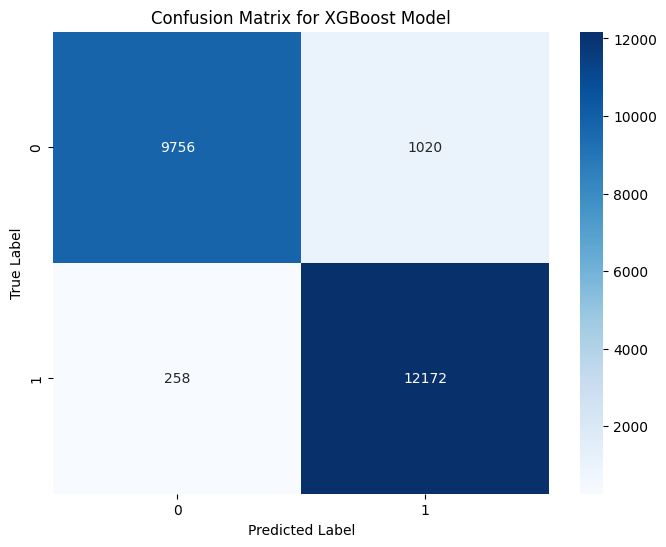

In [33]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_struct, y_pred_test)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for XGBoost Model')
plt.show()


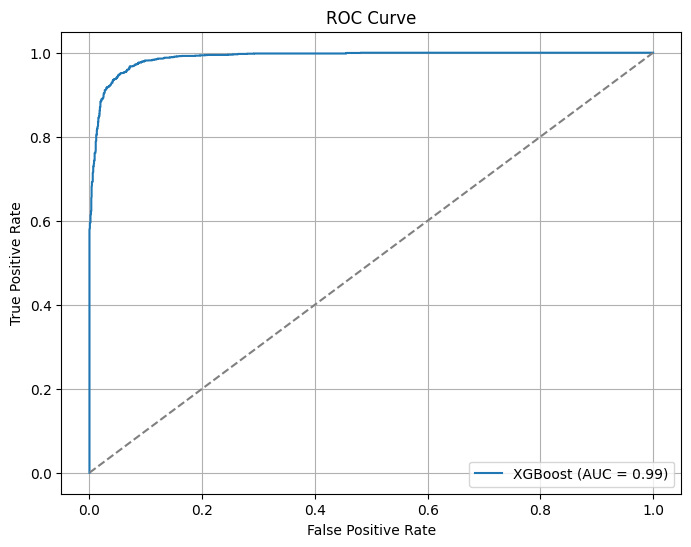

In [8]:
# ROC Curve
roc_auc = roc_auc_score(y_test_struct, y_pred_proba_test)
fpr, tpr, _ = roc_curve(y_test_struct, y_pred_proba_test)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# Save the trained XGBoost model
model_filename = "xgb_model_no_early_stopping.pkl"
with open(model_filename, "wb") as file:
    pickle.dump(xgb_model, file)

print(f"Model saved as {model_filename}")

Model saved as xgb_model_no_early_stopping.pkl


**Add Early Stopping to XGBoost**

In [11]:
# Train the XGBoost model with early stopping
xgb_model_with_early_stopping = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_model_with_early_stopping.fit(
    X_train_struct,
    y_train_struct,
    eval_set=[(X_val_struct, y_val_struct)],  # Use the validation set
    early_stopping_rounds=10,  # Stop training after 10 rounds without improvement
    verbose=True
)

# Predict probabilities for sequential model integration
xgb_features_train = xgb_model_with_early_stopping.predict_proba(X_train_struct)[:, 1]
xgb_features_val = xgb_model_with_early_stopping.predict_proba(X_val_struct)[:, 1]
xgb_features_test = xgb_model_with_early_stopping.predict_proba(X_test_struct)[:, 1]

# Print sample results for debugging
print(f"Validation set predictions (with early stopping):\n{xgb_features_val[:10]}")

[0]	validation_0-logloss:0.65662
[1]	validation_0-logloss:0.63159
[2]	validation_0-logloss:0.61524
[3]	validation_0-logloss:0.60177
[4]	validation_0-logloss:0.59122
[5]	validation_0-logloss:0.58620
[6]	validation_0-logloss:0.58111


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-logloss:0.57560
[8]	validation_0-logloss:0.56660
[9]	validation_0-logloss:0.55937
[10]	validation_0-logloss:0.55476
[11]	validation_0-logloss:0.54953
[12]	validation_0-logloss:0.54406
[13]	validation_0-logloss:0.54020
[14]	validation_0-logloss:0.53746
[15]	validation_0-logloss:0.52942
[16]	validation_0-logloss:0.52649
[17]	validation_0-logloss:0.52546
[18]	validation_0-logloss:0.52419
[19]	validation_0-logloss:0.52154
[20]	validation_0-logloss:0.51114
[21]	validation_0-logloss:0.50415
[22]	validation_0-logloss:0.50213
[23]	validation_0-logloss:0.49720
[24]	validation_0-logloss:0.49584
[25]	validation_0-logloss:0.49031
[26]	validation_0-logloss:0.48462
[27]	validation_0-logloss:0.48292
[28]	validation_0-logloss:0.47942
[29]	validation_0-logloss:0.47915
[30]	validation_0-logloss:0.47716
[31]	validation_0-logloss:0.47672
[32]	validation_0-logloss:0.47384
[33]	validation_0-logloss:0.46997
[34]	validation_0-logloss:0.46273
[35]	validation_0-logloss:0.45943
[36]	validation_0

In [13]:
# Predict on the test set with the model trained with early stopping
y_pred_test = xgb_model_with_early_stopping.predict(X_test_struct)
y_pred_proba_test = xgb_model_with_early_stopping.predict_proba(X_test_struct)[:, 1]

# Print classification report
print("Classification Report (with early stopping):")
print(classification_report(y_test_struct, y_pred_test))

Classification Report (with early stopping):
              precision    recall  f1-score   support

           0       0.97      0.91      0.94     10776
           1       0.92      0.98      0.95     12430

    accuracy                           0.94     23206
   macro avg       0.95      0.94      0.94     23206
weighted avg       0.95      0.94      0.94     23206



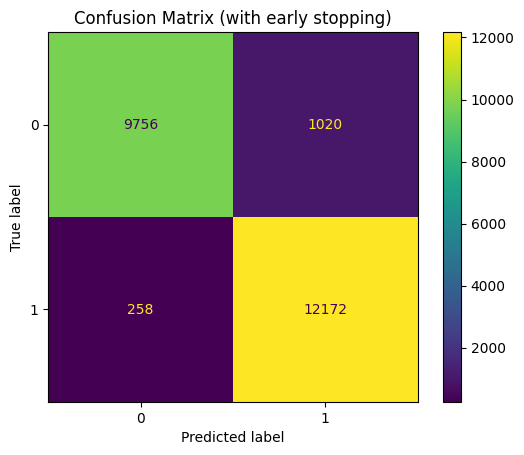

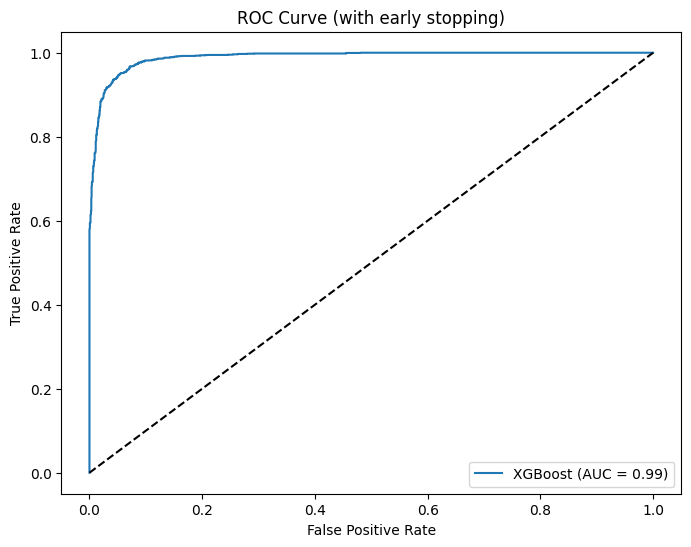

ROC AUC Score: 0.99


In [16]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test_struct, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=xgb_model_with_early_stopping.classes_)
disp.plot(cmap="viridis")
plt.title("Confusion Matrix (with early stopping)")
plt.show()

# ROC Curve
roc_auc = roc_auc_score(y_test_struct, y_pred_proba_test)
fpr, tpr, thresholds = roc_curve(y_test_struct, y_pred_proba_test)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (with early stopping)")
plt.legend()
plt.show()

# Print AUC score for debugging
print(f"ROC AUC Score: {roc_auc:.2f}")

**Early Stopping made no diffence whatsoever**

In [17]:
# Save the trained model with early stopping
model_filename = "xgb_model_with_early_stopping.pkl"
with open(model_filename, "wb") as file:
    pickle.dump(xgb_model_with_early_stopping, file)

print(f"Model with early stopping saved as {model_filename}")

Model with early stopping saved as xgb_model_with_early_stopping.pkl


**Early Stopping + Hyper Paramaeter tuning (Using andom search for best parameter combinations)**

In [18]:
# Define the parameter grid for random search
param_distributions = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'n_estimators': [50, 100, 200, 300],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
}

# Define scoring metric
scorer = make_scorer(f1_score, average='weighted')  # Adjust metric as needed

# Initialize the XGBoost classifier
xgb_model = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=50,
    scoring=scorer,
    cv=3,  # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1,  # Use all available cores
)

# Perform random search
random_search.fit(
    X_train_struct, y_train_struct,
    eval_set=[(X_val_struct, y_val_struct)],
    early_stopping_rounds=10,  # Incorporates early stopping
    verbose=True
)

# Retrieve the best parameters
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# Train the final model with the best parameters
final_model = XGBClassifier(**best_params, random_state=42, use_label_encoder=False)
final_model.fit(
    X_train_struct, y_train_struct,
    eval_set=[(X_val_struct, y_val_struct)],
    early_stopping_rounds=10,
    verbose=True
)

# Predict probabilities on the test set
y_pred_test_tuned = final_model.predict(X_test_struct)
y_pred_proba_test_tuned = final_model.predict_proba(X_test_struct)[:, 1]

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[0]	validation_0-logloss:0.65479
[1]	validation_0-logloss:0.62483
[2]	validation_0-logloss:0.59883
[3]	validation_0-logloss:0.57411
[4]	validation_0-logloss:0.55481


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-logloss:0.53866
[6]	validation_0-logloss:0.52078
[7]	validation_0-logloss:0.51103
[8]	validation_0-logloss:0.49968
[9]	validation_0-logloss:0.48809
[10]	validation_0-logloss:0.47911
[11]	validation_0-logloss:0.47301
[12]	validation_0-logloss:0.46770
[13]	validation_0-logloss:0.46031
[14]	validation_0-logloss:0.45529
[15]	validation_0-logloss:0.44579
[16]	validation_0-logloss:0.44153
[17]	validation_0-logloss:0.43953
[18]	validation_0-logloss:0.43440
[19]	validation_0-logloss:0.43086
[20]	validation_0-logloss:0.42913
[21]	validation_0-logloss:0.42042
[22]	validation_0-logloss:0.41846
[23]	validation_0-logloss:0.41606
[24]	validation_0-logloss:0.40922
[25]	validation_0-logloss:0.40243
[26]	validation_0-logloss:0.40100
[27]	validation_0-logloss:0.39993
[28]	validation_0-logloss:0.39353
[29]	validation_0-logloss:0.38496
[30]	validation_0-logloss:0.38343
[31]	validation_0-logloss:0.37983
[32]	validation_0-logloss:0.37480
[33]	validation_0-logloss:0.37368
[34]	validation_0-l

In [20]:
# Print classification report
from sklearn.metrics import classification_report
print("Classification Report (Tuned XGBoost):")
print(classification_report(y_test_struct, y_pred_test_tuned))

Classification Report (Tuned XGBoost):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10776
           1       1.00      1.00      1.00     12430

    accuracy                           1.00     23206
   macro avg       1.00      1.00      1.00     23206
weighted avg       1.00      1.00      1.00     23206



**Ok this is textbook overfit. We are just going to use XGBoost wihtout hyper parameter tuning to combine with LSTM**

# **Preprocessing Sequential Data for LSTM**

In [21]:
# Load SPY + sentiment data and economic data
merged_data = pd.read_csv('merged_spy_sentiment.csv', parse_dates=['date'], index_col='date')
economic_data = pd.read_csv('economic_data.csv', parse_dates=['Date'], index_col='Date')

# Merge economic data with SPY + sentiment data
merged_data = merged_data.join(economic_data, how='inner')  # Join on the index (dates)

# Sequential features (including economic indicators)
sequential_features = ['Close', 'compound', 'Unemployment Rate', 'Fed Funds Rate']

# Check for missing values after merging
merged_data = merged_data.dropna(subset=sequential_features)  # Drop rows with missing sequential features

# Sequential data (features for LSTM)
sequential_data = merged_data[sequential_features]

# Define sequence length
sequence_length = 10  # Look back 10 days

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i + seq_length].values)  # Extract sequences of features
        y.append(merged_data.iloc[i + seq_length]['Return_1D'])  # Target is at the end of each sequence
    return np.array(X), np.array(y)

# Generate sequences
X_seq, y_seq = create_sequences(sequential_data, sequence_length)

# Convert target variable to binary classification (increase = 1, no increase = 0)
y_seq = (y_seq > 0).astype(int)

# Normalize sequential features
scaler = MinMaxScaler()
X_seq = scaler.fit_transform(X_seq.reshape(-1, X_seq.shape[-1])).reshape(X_seq.shape)

In [22]:
# First, split the data into training+validation and testing
X_train_val_seq, X_test_seq, y_train_val_seq, y_test_seq = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42
)

# Then, split the training+validation into separate training and validation sets
X_train_seq, X_val_seq, y_train_seq, y_val_seq = train_test_split(
    X_train_val_seq, y_train_val_seq, test_size=0.2, random_state=42
)

print(f"X_train_seq shape: {X_train_seq.shape}, X_val_seq shape: {X_val_seq.shape}, X_test_seq shape: {X_test_seq.shape}")
print(f"y_train_seq shape: {y_train_seq.shape}, y_val_seq shape: {y_val_seq.shape}, y_test_seq shape: {y_test_seq.shape}")

X_train_seq shape: (3096, 10, 4), X_val_seq shape: (774, 10, 4), X_test_seq shape: (968, 10, 4)
y_train_seq shape: (3096,), y_val_seq shape: (774,), y_test_seq shape: (968,)


# **Combining XGBoost (just the Untuned version) and LSTM Features**

In [23]:
# Expand XGBoost features to match the sequence length
xgb_features_train_expanded = np.repeat(xgb_features_train[:len(X_train_seq)].reshape(-1, 1, 1), X_train_seq.shape[1], axis=1)
xgb_features_val_expanded = np.repeat(xgb_features_val[:len(X_val_seq)].reshape(-1, 1, 1), X_val_seq.shape[1], axis=1)
xgb_features_test_expanded = np.repeat(xgb_features_test[:len(X_test_seq)].reshape(-1, 1, 1), X_test_seq.shape[1], axis=1)

# Add XGBoost probabilities as an additional feature to the sequential model
X_train_combined = np.concatenate([X_train_seq, xgb_features_train_expanded], axis=2)
X_val_combined = np.concatenate([X_val_seq, xgb_features_val_expanded], axis=2)
X_test_combined = np.concatenate([X_test_seq, xgb_features_test_expanded], axis=2)

print(f"X_train_combined shape: {X_train_combined.shape}")
print(f"X_val_combined shape: {X_val_combined.shape}")
print(f"X_test_combined shape: {X_test_combined.shape}")

X_train_combined shape: (3096, 10, 5)
X_val_combined shape: (774, 10, 5)
X_test_combined shape: (968, 10, 5)


In [24]:
def create_lstm_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(64, return_sequences=True, input_shape=input_shape),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Define the updated LSTM model
input_shape = (X_train_combined.shape[1], X_train_combined.shape[2])  # Updated input shape
lstm_model_combined = create_lstm_model(input_shape)

# Set up early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the combined model
history_combined = lstm_model_combined.fit(
    X_train_combined, y_train_seq,
    validation_data=(X_val_combined, y_val_seq),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the combined model on the test set
test_loss_combined, test_accuracy_combined = lstm_model_combined.evaluate(X_test_combined, y_test_seq, verbose=1)
print(f"Test Loss (combined): {test_loss_combined}, Test Accuracy (combined): {test_accuracy_combined}")

# Predict on the test set with the combined model
y_pred_prob_combined = lstm_model_combined.predict(X_test_combined).flatten()
y_pred_combined = (y_pred_prob_combined > 0.5).astype(int)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6128 - loss: 0.6696 - val_accuracy: 0.6576 - val_loss: 0.6330
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6264 - loss: 0.6547 - val_accuracy: 0.6886 - val_loss: 0.6145
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6377 - loss: 0.6397 - val_accuracy: 0.6951 - val_loss: 0.5958
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6505 - loss: 0.6163 - val_accuracy: 0.6951 - val_loss: 0.6055
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6392 - loss: 0.6311 - val_accuracy: 0.6860 - val_loss: 0.5920
Epoch 6/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6732 - loss: 0.6029 - val_accuracy: 0.6964 - val_loss: 0.5845
Epoch 7/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6485 - loss: 0.6151 - val_accuracy: 0.6977 - val_loss: 0.5934
Epoch 8/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6550 - loss: 0.6023 - val_accuracy: 0.7016 - val_loss:

In [25]:
# Classification report
from sklearn.metrics import classification_report
print("Classification Report (combined):")
print(classification_report(y_test_seq, y_pred_combined))

Classification Report (combined):
              precision    recall  f1-score   support

           0       0.81      0.49      0.61       357
           1       0.76      0.93      0.83       611

    accuracy                           0.77       968
   macro avg       0.78      0.71      0.72       968
weighted avg       0.77      0.77      0.75       968



In [26]:
# Confusion matrix
conf_matrix_combined = confusion_matrix(y_test_seq, y_pred_combined)
print("Confusion Matrix (combined):")
print(conf_matrix_combined)

Confusion Matrix (combined):
[[174 183]
 [ 42 569]]


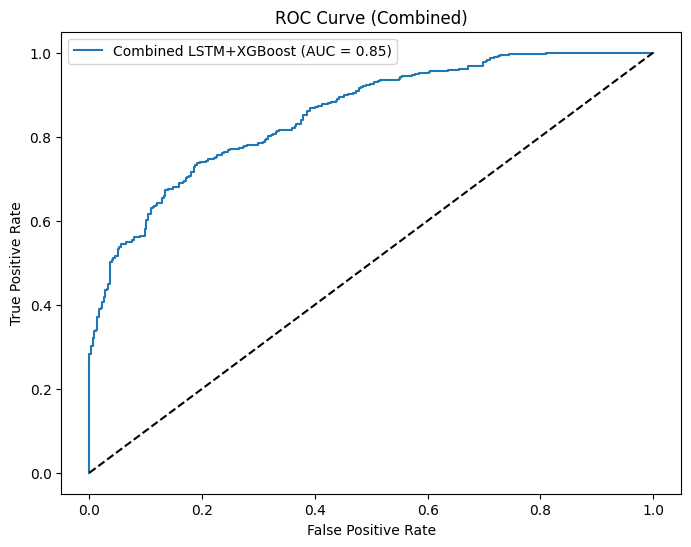

In [27]:
# ROC Curve and AUC Score
roc_auc_combined = roc_auc_score(y_test_seq, y_pred_prob_combined)
fpr_combined, tpr_combined, thresholds_combined = roc_curve(y_test_seq, y_pred_prob_combined)
plt.figure(figsize=(8, 6))
plt.plot(fpr_combined, tpr_combined, label=f"Combined LSTM+XGBoost (AUC = {roc_auc_combined:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Combined)')
plt.legend()
plt.show()

In [28]:
# Save the trained combined LSTM model
lstm_model_combined.save("lstm_xgb_combined_model_not_tuned.h5")
print("Combined LSTM+XGBoost model saved as 'lstm_xgb_combined_model_untuned.h5'")

Combined LSTM+XGBoost model saved as 'lstm_xgb_combined_model_untuned.h5'


# **Fine tuning LSTM Using Random Search**

In [29]:
# Define function to create an LSTM model with parameters
def create_lstm_model(units=64, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential([
        LSTM(units, return_sequences=True, input_shape=(X_train_combined.shape[1], X_train_combined.shape[2])),
        Dropout(dropout_rate),
        LSTM(units // 2),
        Dropout(dropout_rate),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Hyperparameter grid
param_grid = {
    "units": [32, 64, 128],
    "dropout_rate": [0.2, 0.3, 0.5],
    "learning_rate": [0.001, 0.005, 0.01],
    "batch_size": [32, 64],
    "epochs": [20]
}

# Track best parameters and results
best_params = None
best_accuracy = 0
best_model = None

# Fine-tuning loop
for units in param_grid["units"]:
    for dropout_rate in param_grid["dropout_rate"]:
        for learning_rate in param_grid["learning_rate"]:
            for batch_size in param_grid["batch_size"]:
                print(f"Training model with units={units}, dropout_rate={dropout_rate}, learning_rate={learning_rate}, batch_size={batch_size}")

                # Create and train model
                model = create_lstm_model(units, dropout_rate, learning_rate)
                history = model.fit(
                    X_train_combined, y_train_seq,
                    validation_data=(X_val_combined, y_val_seq),
                    epochs=param_grid["epochs"][0],
                    batch_size=batch_size,
                    verbose=0
                )

                # Evaluate on validation set
                val_loss, val_accuracy = model.evaluate(X_val_combined, y_val_seq, verbose=0)
                print(f"Validation Accuracy: {val_accuracy}")

                # Track the best model
                if val_accuracy > best_accuracy:
                    best_accuracy = val_accuracy
                    best_params = {"units": units, "dropout_rate": dropout_rate, "learning_rate": learning_rate, "batch_size": batch_size}
                    best_model = model

print(f"Best Parameters: {best_params}")
print(f"Best Validation Accuracy: {best_accuracy}")

# Evaluate the best model on the test set
test_loss, test_accuracy = best_model.evaluate(X_test_combined, y_test_seq, verbose=1)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Predict on the test set
y_pred_prob_tuned = best_model.predict(X_test_combined).flatten()
y_pred_tuned = (y_pred_prob_tuned > 0.5).astype(int)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training model with units=32, dropout_rate=0.2, learning_rate=0.001, batch_size=32
Validation Accuracy: 0.6963824033737183
Training model with units=32, dropout_rate=0.2, learning_rate=0.001, batch_size=64
Validation Accuracy: 0.6873385310173035
Training model with units=32, dropout_rate=0.2, learning_rate=0.005, batch_size=32
Validation Accuracy: 0.6912144422531128
Training model with units=32, dropout_rate=0.2, learning_rate=0.005, batch_size=64
Validation Accuracy: 0.6666666865348816
Training model with units=32, dropout_rate=0.2, learning_rate=0.01, batch_size=32
Validation Accuracy: 0.6744186282157898
Training model with units=32, dropout_rate=0.2, learning_rate=0.01, batch_size=64
Validation Accuracy: 0.6937984228134155
Training model with units=32, dropout_rate=0.3, learning_rate=0.001, batch_size=32
Validation Accuracy: 0.6950904130935669
Training model with units=32, dropout_rate=0.3, learning_rate=0.001, batch_size=64
Validation Accuracy: 0.6770026087760925
Training model wit

In [30]:
# Classification report
print("Classification Report (Tuned LSTM):")
print(classification_report(y_test_seq, y_pred_tuned))


Classification Report (Tuned LSTM):
              precision    recall  f1-score   support

           0       0.71      0.17      0.27       357
           1       0.66      0.96      0.78       611

    accuracy                           0.67       968
   macro avg       0.69      0.56      0.53       968
weighted avg       0.68      0.67      0.59       968



In [31]:
# Save the combined model
lstm_model_combined.save("lstm_xgb_combined_model_tuned.h5")
print("Combined LSTM+XGBoost model saved as 'lstm_xgb_combined_model_tuned.h5'")

Combined LSTM+XGBoost model saved as 'lstm_xgb_combined_model_tuned.h5'


**The best performing model was just XGBoost with no hyperparamter tuning and no early stopping!!!**

**Addind economic data to XGBoost**

In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Load SPY + sentiment data and economic data
merged_data = pd.read_csv('merged_spy_sentiment.csv', parse_dates=['date'], index_col='date')
economic_data = pd.read_csv('economic_data.csv', parse_dates=['Date'], index_col='Date')

# Merge economic data with SPY + sentiment data
merged_data = merged_data.join(economic_data, how='inner')  # Join on the index (dates)

# Select structured features including economic data
structured_features = ['SMA_20', 'RSI_14', 'BB_High', 'BB_Low', 'compound', 'Unemployment Rate', 'Fed Funds Rate']
target = 'Return_1D'

# Normalize the structured features
scaler = MinMaxScaler()
X_structured = scaler.fit_transform(merged_data[structured_features])
y = (merged_data[target] > 0).astype(int)

# Train-test split for structured model
X_train_struct, X_temp_struct, y_train_struct, y_temp_struct = train_test_split(X_structured, y, test_size=0.3, random_state=42)

# Split temp data into validation and test sets
X_val_struct, X_test_struct, y_val_struct, y_test_struct = train_test_split(X_temp_struct, y_temp_struct, test_size=0.5, random_state=42)

# Train the XGBoost model without early stopping
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(
    X_train_struct,
    y_train_struct,
    verbose=True
)

# Predict probabilities for sequential model integration
xgb_features_train = xgb_model.predict_proba(X_train_struct)[:, 1]
xgb_features_val = xgb_model.predict_proba(X_val_struct)[:, 1]
xgb_features_test = xgb_model.predict_proba(X_test_struct)[:, 1]

# Predict on test set
y_pred_test = xgb_model.predict(X_test_struct)
y_pred_prob_test = xgb_model.predict_proba(X_test_struct)[:, 1]


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [40]:
# Manual calculation of classification report
from collections import Counter

# True positives, false positives, true negatives, and false negatives
tp = sum((y_test_struct == 1) & (y_pred_test == 1))  # True Positives
fp = sum((y_test_struct == 0) & (y_pred_test == 1))  # False Positives
tn = sum((y_test_struct == 0) & (y_pred_test == 0))  # True Negatives
fn = sum((y_test_struct == 1) & (y_pred_test == 0))  # False Negatives

# Total samples
total_samples = len(y_test_struct)

# Accuracy
accuracy = (tp + tn) / total_samples

# Precision, Recall, and F1-Score for each class
precision_1 = tp / (tp + fp) if (tp + fp) > 0 else 0
recall_1 = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score_1 = 2 * (precision_1 * recall_1) / (precision_1 + recall_1) if (precision_1 + recall_1) > 0 else 0

precision_0 = tn / (tn + fn) if (tn + fn) > 0 else 0
recall_0 = tn / (tn + fp) if (tn + fp) > 0 else 0
f1_score_0 = 2 * (precision_0 * recall_0) / (precision_0 + recall_0) if (precision_0 + recall_0) > 0 else 0

# Macro-average (average of both classes)
macro_precision = (precision_0 + precision_1) / 2
macro_recall = (recall_0 + recall_1) / 2
macro_f1 = (f1_score_0 + f1_score_1) / 2

# Weighted average (weighted by class support)
support_0 = Counter(y_test_struct)[0]
support_1 = Counter(y_test_struct)[1]

weighted_precision = (precision_0 * support_0 + precision_1 * support_1) / total_samples
weighted_recall = (recall_0 * support_0 + recall_1 * support_1) / total_samples
weighted_f1 = (f1_score_0 * support_0 + f1_score_1 * support_1) / total_samples

# Display metrics
print("Manual Classification Report:")
print(f"Class 0: Precision={precision_0:.2f}, Recall={recall_0:.2f}, F1-Score={f1_score_0:.2f}, Support={support_0}")
print(f"Class 1: Precision={precision_1:.2f}, Recall={recall_1:.2f}, F1-Score={f1_score_1:.2f}, Support={support_1}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Macro Avg: Precision={macro_precision:.2f}, Recall={macro_recall:.2f}, F1-Score={macro_f1:.2f}")
print(f"Weighted Avg: Precision={weighted_precision:.2f}, Recall={weighted_recall:.2f}, F1-Score={weighted_f1:.2f}")


Manual Classification Report:
Class 0: Precision=1.00, Recall=1.00, F1-Score=1.00, Support=259
Class 1: Precision=1.00, Recall=1.00, F1-Score=1.00, Support=469
Accuracy: 1.00
Macro Avg: Precision=1.00, Recall=1.00, F1-Score=1.00
Weighted Avg: Precision=1.00, Recall=1.00, F1-Score=1.00


In [44]:
tp = sum((y_test_struct == 1) & (y_pred_test == 1))
tn = sum((y_test_struct == 0) & (y_pred_test == 0))
fp = sum((y_test_struct == 0) & (y_pred_test == 1))
fn = sum((y_test_struct == 1) & (y_pred_test == 0))
print(f"True Positives: {tp}, True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}")


True Positives: 469, True Negatives: 259, False Positives: 0, False Negatives: 0


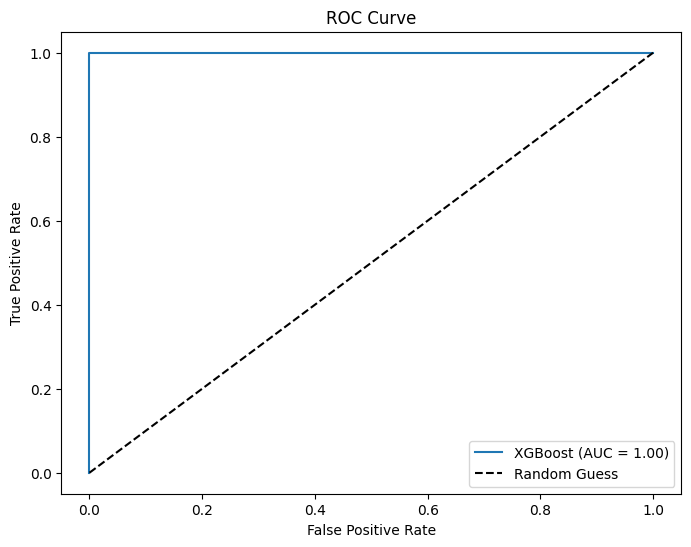

In [37]:

# ROC Curve and AUC Score
roc_auc = roc_auc_score(y_test_struct, y_pred_prob_test)
fpr, tpr, thresholds = roc_curve(y_test_struct, y_pred_prob_test)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [45]:

# Save the updated XGBoost model
import pickle
with open("xgb_model_with_econ_data.pkl", "wb") as file:
    pickle.dump(xgb_model, file)
print("Model saved as 'xgb_model_with_econ_data.pkl'")


Model saved as 'xgb_model_with_econ_data.pkl'


**Adding Economic Data (Unemployment and Interest Rate) to XGboost Overfit the model!**

In [46]:
import pickle
import matplotlib.pyplot as plt

# Load the saved XGBoost model
model_filename = "xgb_model_no_early_stopping.pkl"
with open(model_filename, "rb") as file:
    xgb_model_loaded = pickle.load(file)

print("XGBoost model loaded successfully.")


XGBoost model loaded successfully.


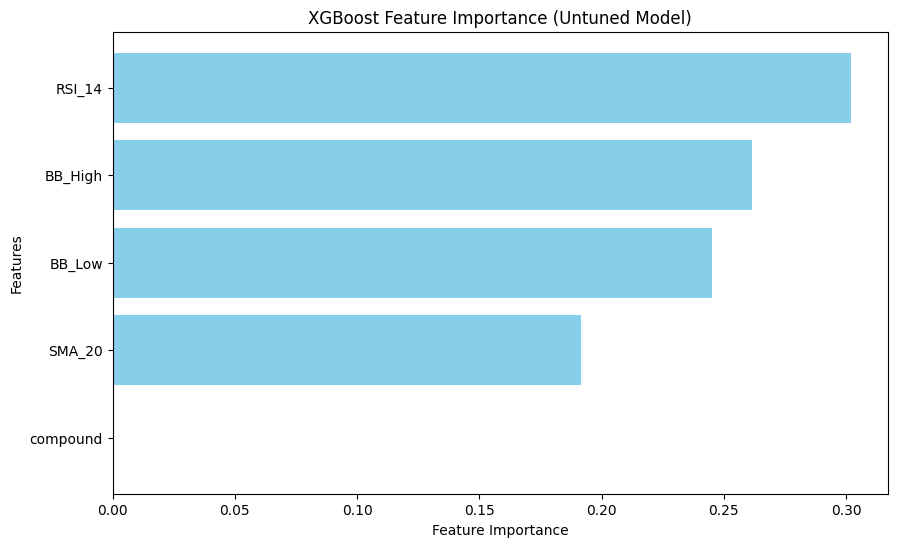

In [47]:
import numpy as np

# Define feature names
feature_names = ['SMA_20', 'RSI_14', 'BB_High', 'BB_Low', 'compound', 'Unemployment Rate', 'Fed Funds Rate']

# Extract feature importances
feature_importance = xgb_model_loaded.feature_importances_

# Sort feature importances for visualization
sorted_idx = np.argsort(feature_importance)[::-1]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(np.array(feature_names)[sorted_idx], feature_importance[sorted_idx], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("XGBoost Feature Importance (Untuned Model)")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()


In [48]:
print(merged_data[['compound', 'Return_1D']].corr())


           compound  Return_1D
compound   1.000000   0.000013
Return_1D  0.000013   1.000000


The correlation between compound and the target variable Return_1D is effectively 0 (0.000013), which explains why XGBoost assigned it no importance. This indicates that the sentiment score (compound) has no linear relationship with the one-day return (Return_1D), at least in this dataset.
